In [1]:
# Not all of these will be used, remove as needed
import os
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import binary_dilation
from scipy.signal import butter, filtfilt, wiener
from scipy.ndimage import uniform_filter, variance, generic_filter, gaussian_filter
from scipy.fftpack import fft2, ifft2, fftshift
from tqdm import tqdm
from skimage import io, filters, morphology
from skimage.util import img_as_ubyte
from skimage.filters import rank, sobel
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk
import heapq

In [2]:
# List of files for Dan to test
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_1_2024-01-11_Confocal_01.00.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_2_2024-01-11_Confocal_01.16.28_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_3_2024-01-11_Confocal_01.08.43_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_1_2024-01-11_Confocal_01.23.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_2_2024-01-11_Confocal_01.30.50_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_3_2024-01-11_Confocal_01.40.34_DragonflyUser.ims'
# '/Users/moose/Downloads/Controls 20240418/PBP4_2024-04-18_Confocal_01.02.30_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 2_2024-01-10_Confocal_22.46.39_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 3_2024-01-11_Confocal_00.32.47_DragonflyUser.ims'
# '/Users/moose/Downloads/Controls 20240418/Nonporous_2024-04-18_Confocal_00.19.10_DragonflyUser.ims'

# Select Datasets
# '/Volumes/SSD/Mike/1.21 OD Device 4_6 Hours_2023-03-15_GFP Staph Aureus_22.39.28_DragonflyUser.ims'
# '/Volumes/SSD/Mike/Od 1.187 Device 1_6 hours_2023-03-03_GFP Staph Aureus_22.24.24_DragonflyUser.ims'
# '/Volumes/SSD/Mike/Od 1.187 Device 2_6 hours_2023-03-03_GFP Staph Aureus_21.44.39_DragonflyUser.ims'


# '/Users/moose/Downloads/Controls 20240418/WT DNase_2024-04-18_Confocal_00.55.19_DragonflyUser.ims'

# '/Users/moose/Downloads/Controls 20240418/WT 1 window_2024-04-18_Confocal_00.33.17_DragonflyUser_FusionStitcher.ims' Do not use!

# '/Users/moose/Downloads/Controls 20240418/WT 1 stack_2024-04-18_Confocal_00.48.57_DragonflyUser.ims' Good test stack for budding events, slightly tilted.

# '/Users/moose/Downloads/Analysis Data Set 06212024/Nonporous_2_2024-06-21_Confocal_00.41.15_DragonflyUser.ims'
# '/Users/moose/Downloads/Analysis Data Set 06212024/DNase_1_2024-06-20_Confocal_23.51.58_DragonflyUser.ims'

In [3]:
# Load raw ims file here

file_name = '/Users/moose/Downloads/Analysis Data Set 06212024/DNase_1_2024-06-20_Confocal_23.51.58_DragonflyUser.ims'
image = AICSImage(file_name)
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


In [4]:
# Global variables
key_frame = '/Users/moose/Desktop/trace_ca-local/key-frame-ca-norm2.tif'
key_img = io.imread(key_frame)
norm_flat = key_img # Need to fix in code for clarity, this variable is redundant.

# Some of these are not used, remove later
DoG_thresh = 0.3
lowerbound = 2
search_mod = 25
z_project = 10
bloom_mod = 1

BlurToggle = False
gkernal = (21, 21)

DilateToggle = False
dstructure = np.ones((3, 3))

In [5]:
# All functions
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

def means_match(input_img, kfimg):
        # kfmod = subtractflatfield(kfimg)
        # kfmod = kfmod-np.min(kfmod)
        kfmod = kfimg
        kfmean = np.mean(kfmod)

        # xmod_loss = []

        best_mean_diff = np.inf
        best_xmod = 0
        mean_diff = 0
        bftest = input_img
        bfmin = np.min(bftest)
            
        for xmod in tqdm(np.linspace(0.01, 10, 500), desc='Means Matching'):
            xmodtest = np.clip(xmod * (bftest), np.min(kfimg), np.max(kfimg))
            mean_xmodtest = np.mean(xmodtest)
            mean_diff = abs(mean_xmodtest - kfmean)

            # xmod_loss = mean_diff # Diagnostic
                
            if mean_diff < best_mean_diff:
                best_mean_diff = mean_diff
                best_xmod = xmod

            if mean_diff < 0.0005:
                print(f'Image is at an acceptable target, stopping iterations')
                break

            bfimg = np.clip(best_xmod * (input_img - np.min(input_img)), np.min(kfimg), np.max(kfimg))

        return bfimg, kfmod, best_xmod

In [6]:
flattened_im_data = []
for i in tqdm(range(len(image_data)), desc='Removing background from stack'):
    flattened_im_data.append(subtractflatfield(image_data[i]))

Removing background from stack: 100%|██████████| 41/41 [00:17<00:00,  2.29it/s]


In [7]:
# Initial image processing
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

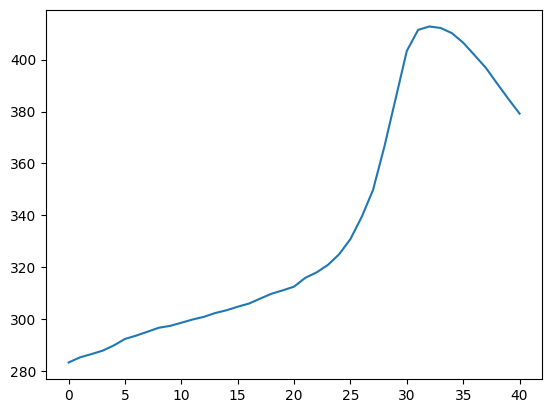

In [8]:
plt.plot(frame_mean, label='Mean')

In [9]:
# Peak detection
background_collect = background_subtract(frame_mean)
peaks2, _ = find_peaks(background_collect, height = 1)

if len(peaks2) == 0:
    max_key = {}
    for i in range(len(background_collect)):
        max_key[i] = background_collect[i]
    true_max = max(max_key.keys())
    peaks2 = [true_max]

if len(peaks2) > 1:
    print('Multiple peaks detected, selecting the highest peak')
    max_key = {}
    for i in range(len(background_collect)):
        max_key[i] = background_collect[i]
    true_max = max(max_key.keys())
    peaks2 = [true_max]

print(peaks2)

[32]


In [10]:
# Generate ensemble model for focus measure voting
hist_key = {}

for i in range(peaks2[0]-search_mod, peaks2[0]):
    if i > 0:
        hist_key[i] = image_data[i]

for i in range(peaks2[0], peaks2[0]+search_mod+1):
    if i < len(image_data):
        hist_key[i] = image_data[i]

hist_stdev = {}
for i in hist_key.keys():
    hist_stdev[i] = np.std(hist_key[i])

hist_laplace = {}
hist_laplace_focusemeasure = {}
for i in hist_key.keys():
    hist_laplace[i] = cv2.Laplacian(hist_key[i], cv2.CV_64F)
    hist_laplace_focusemeasure[i] = np.var(hist_laplace[i])

hist_tenengrad_focusemeasure = {}
hist_squared_grad = {}
for i in hist_key.keys():
    sobelx = cv2.Sobel(hist_key[i], cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(hist_key[i], cv2.CV_64F, 0, 1, ksize=5)

    magnitude = np.sqrt(sobelx**2 + sobely**2)
    squared_grad = (sobelx**2 + sobely**2)

    hist_tenengrad_focusemeasure[i] = np.var(magnitude)
    hist_squared_grad[i] = np.var(squared_grad)


hist_brenner_focusemeasure = {}
for i in hist_key.keys():
    shifted_right = np.roll(hist_key[i], -1, axis=1)
    shifted_down = np.roll(hist_key[i], -1, axis=0)

    diff_right = (shifted_right - hist_key[i])[:-1, :-1] ** 2
    diff_down = (shifted_down - hist_key[i])[:-1, :-1] ** 2

    sum_diff = np.sum(diff_right) + np.sum(diff_down)
    hist_brenner_focusemeasure[i] = sum_diff

hist_max = {}
for i in hist_key.keys():
    hist_max[i] = np.max(hist_key[i])

In [11]:
# Finalize vote

weight_mat = [1, 1, 1, 1, 1, 1]
focus_margins = []

# stdev_two_largest = heapq.nlargest(2, hist_stdev.values())
# laplace_two_largest = heapq.nlargest(2, hist_laplace_focusemeasure.values())
# tenengrad_two_largest = heapq.nlargest(2, hist_tenengrad_focusemeasure.values())

stdev_stdev = np.std(list(hist_stdev.values()))
laplace_stdev = np.std(list(hist_laplace_focusemeasure.values()))
tenengrad_stdev = np.std(list(hist_tenengrad_focusemeasure.values()))
squared_grad_stdev = np.std(list(hist_squared_grad.values()))
brenner_stdev = np.std(list(hist_brenner_focusemeasure.values()))


weight_mat[0] = stdev_stdev/np.mean(list(hist_stdev.values()))
weight_mat[1] = laplace_stdev/np.mean(list(hist_laplace_focusemeasure.values()))
weight_mat[2] = tenengrad_stdev/np.mean(list(hist_tenengrad_focusemeasure.values()))*3 # Extra weight on Tenengrad
weight_mat[3] = squared_grad_stdev/np.mean(list(hist_squared_grad.values()))
weight_mat[4] = brenner_stdev/np.mean(list(hist_brenner_focusemeasure.values()))

focus_ensemble = []
focus_ensemble.append(max(hist_stdev, key=hist_stdev.get))
focus_ensemble.append(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get))
focus_ensemble.append(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get))
focus_ensemble.append(max(hist_squared_grad, key=hist_squared_grad.get))
focus_ensemble.append(max(hist_brenner_focusemeasure, key=hist_brenner_focusemeasure.get))

voting_power = []
for i in range(len(focus_ensemble)):
    voting_power.append((focus_ensemble[i], weight_mat[i]))

vote = {}
for frame_num, weighted_vote in voting_power:
    if frame_num in vote:
        vote[frame_num] += weighted_vote

    else:
        vote[frame_num] = weighted_vote

print(f'Final Vote - Membrane Layer at:  ' + str(max(vote, key=vote.get)))
mem_layer = max(vote, key=vote.get)

Final Vote - Membrane Layer at:  29


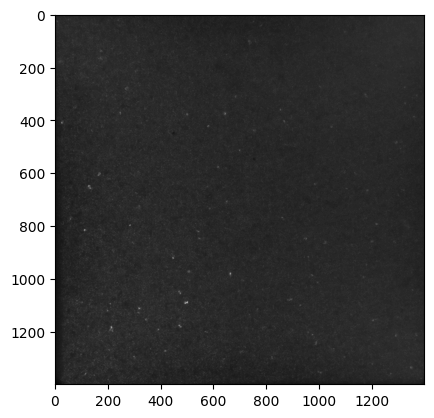

In [12]:
plt.imshow(flattened_im_data[mem_layer-2], cmap='gray')

In [13]:
# A ridiculous way to estimate the Wiener kernel size
# Takes variance, divides by mean/min. Sensitive to edge cases
# kern_size = int(np.sqrt(variance(image_data[mem_layer]))/(np.mean(image_data[mem_layer])/np.min(image_data[mem_layer])))
# kern_size = kern_size +1 if kern_size % 2 == 0 else kern_size
# kern_size

In [14]:
# Create z-projection

bud_test = []
for i in range(z_project):
    bud_test.append(mem_layer-i-bloom_mod)

bud_test_img = []
for i in bud_test:
    bud_test_img.append(flattened_im_data[i])

bud_composite = np.max(bud_test_img, axis=0)

bud_img = bud_composite

In [15]:
# Process z-projection and normalize brightness.
# bud_norm = (bud_img - np.min(bud_img)) / (np.max(bud_img) - np.min(bud_img))
# bud_norm = img_as_ubyte(bud_norm)


bud_sub = bud_img
bud_sub = (bud_sub - np.min(bud_sub)) / (np.max(bud_sub) - np.min(bud_sub))
bud_sub = img_as_ubyte(bud_sub)  


bud_matched, kf_fin,  xtest = means_match(bud_sub, norm_flat)

Means Matching:   0%|          | 0/500 [00:00<?, ?it/s]

Means Matching: 100%|██████████| 500/500 [00:03<00:00, 139.23it/s]


In [16]:
xtest

2.5925851703406813

In [17]:
# # A more reasonable way to estimate the Wiener kernel size using some spatial analysis
# def edge_density(image):
#     edges = sobel(image)
#     return edges.mean()

# def local_variance(image):
#     return generic_filter(image, np.var, size=3)

# def frequency_analysis(image):
#     f_transform = fft2(image)
#     f_shifted = fftshift(f_transform)
#     magnitude_spectrum = np.abs(f_shifted)
#     mean_frequency = magnitude_spectrum.mean()
#     return mean_frequency

# edge_dens = edge_density(image_data[mem_layer])
# var_im = local_variance(bud_matched).mean()
# freq_im = frequency_analysis(bud_matched)

# # heuristic using edge density
# kern_size2 = edge_dens
# kern_size2 = kern_size2 +1 if kern_size2 % 2 == 0 else kern_size2
# print(kern_size2)

In [18]:
# filtered_bud = wiener(bud_matched, mysize=int(kern_size2))
# plt.imshow(filtered_bud, cmap='gray')

In [19]:
# filtered_bud2 = gaussian_filter(bud_matched, kern_size2)
# plt.imshow(filtered_bud2, cmap='gray')

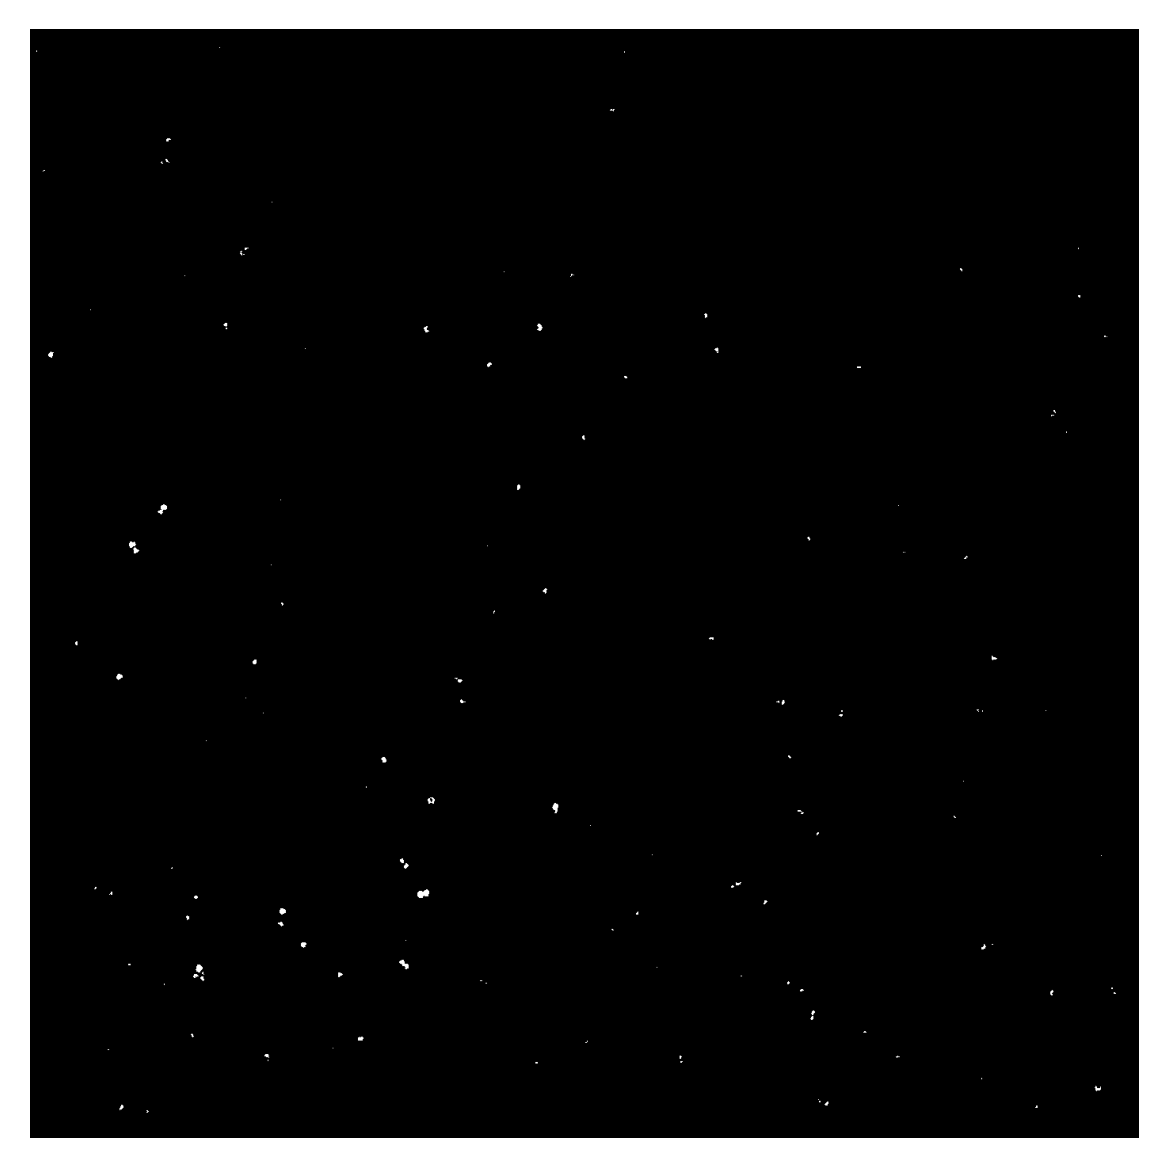

Raw Regions: 140
Filtered Regions: 31


In [20]:
# Image processing for budding events
# Threshold image
bud_thresh = np.percentile(bud_matched, 99.9)
bud_brightest = np.where(bud_matched > bud_thresh, 256, 0)

# bud_brightest2 = np.where(filtered_bud > 256*0.5, 256, 0)

plt.figure(dpi=300)
plt.imshow(bud_brightest, cmap='gray')
plt.axis('off')
# plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_binary.tif', dpi=500)
plt.show()

# Morphological analysis
closed_im = morphology.closing(bud_brightest, morphology.square(1))
label_im = measure.label(closed_im)
region_im = measure.regionprops(label_im, intensity_image=bud_matched)
# for part in region_im:
#     print('Label: {} Area: {}'.format(part.label, part.area))

area_list = []
for part in region_im:
    area_list.append(part.area)

# delete_small_components = filters.threshold_otsu(np.array(area_list)) 
# area_list = [part for part in area_list if delete_small_components < part < 10000]

intensity_list = []
for part in region_im:
    intensity_list.append(part.mean_intensity)

# int_cut = np.percentile(intensity_list, 50)
# intensity_list = [part for part in intensity_list if  int_cut < part]

# eccentricity_list = []
# for part in region_im:
#     eccentricity_list.append(part.eccentricity)

# eccentricity_list = [part for part in eccentricity_list if 0.05 < part < 0.99]

area_list_thresh = np.percentile(area_list, 50)
mean_comp = np.percentile(intensity_list, 50)
# std_mean_comp = np.std([part for part in intensity_list if part > mean_comp])
# # mean_comp = np.percentile(norm_flat, 99.8)
# lower_ecc = np.percentile(eccentricity_list, 2)
# higher_ecc = np.percentile(eccentricity_list, 98)

filter_area_low = area_list_thresh 
# filter_eccentricity_low = lower_ecc
# filter_eccentricity_high = higher_ecc
# region_im_filtered = [part for part in region_im if part.mean_intensity > mean_comp]
# region_im_filtered = [part for part in region_im_filtered if filter_area_low < part.area < 10000]
# region_im_filtered = [part for part in region_im_filtered if filter_eccentricity_low < part.eccentricity < filter_eccentricity_high]

region_im_filtered = [
                      # part for part in region_im 
                      # if part.intensity_mean > np.max([mean_comp, 135])
                      # and np.max([filter_area_low, 15]) < part.area < 10000 
                      # and filter_eccentricity_low < part.eccentricity < filter_eccentricity_high
                      # and part.intensity_max > 240
                    part for part in region_im
                    if np.max([filter_area_low, 15]) < part.area < 10000 
                    and part.intensity_max > 250
                    and part.intensity_mean > np.max([135, mean_comp])
                    and part.intensity_max - part.intensity_mean > 25
                    and part.intensity_mean - part.intensity_min > 30
                      ]

print('Raw Regions: {}'.format(len(region_im)))
print('Filtered Regions: {}'.format(len(region_im_filtered)))

In [21]:
np.mean(bud_matched)*3

232.71920517351032

In [22]:
for part in region_im_filtered:
      print('Centroid: ({:.0f}, {:.0f}) | '
            'Area: {} | '
            'Eccentricity {:.2f} | '
            'Mean Intensity {:.2f} | '
            'Min Intensity {:.2f} |'
            'Max Intensity {:.2f}'.format(part.centroid[0], 
                                          part.centroid[1], 
                                          part.area, 
                                          part.eccentricity, 
                                          part.mean_intensity,
                                          part.min_intensity, 
                                          part.intensity_max))

Centroid: (361, 853) | Area: 16.0 | Eccentricity 0.80 | Mean Intensity 214.06 | Min Intensity 171.11 |Max Intensity 255.00
Centroid: (373, 246) | Area: 17.0 | Eccentricity 0.41 | Mean Intensity 218.55 | Min Intensity 186.67 |Max Intensity 255.00
Centroid: (376, 643) | Area: 42.0 | Eccentricity 0.77 | Mean Intensity 228.42 | Min Intensity 171.11 |Max Intensity 255.00
Centroid: (379, 500) | Area: 30.0 | Eccentricity 0.79 | Mean Intensity 217.12 | Min Intensity 173.70 |Max Intensity 255.00
Centroid: (405, 867) | Area: 20.0 | Eccentricity 0.77 | Mean Intensity 210.66 | Min Intensity 171.11 |Max Intensity 255.00
Centroid: (411, 26) | Area: 35.0 | Eccentricity 0.61 | Mean Intensity 227.98 | Min Intensity 171.11 |Max Intensity 255.00
Centroid: (423, 579) | Area: 23.0 | Eccentricity 0.78 | Mean Intensity 228.40 | Min Intensity 173.70 |Max Intensity 255.00
Centroid: (578, 616) | Area: 23.0 | Eccentricity 0.83 | Mean Intensity 218.24 | Min Intensity 173.70 |Max Intensity 255.00
Centroid: (605, 1

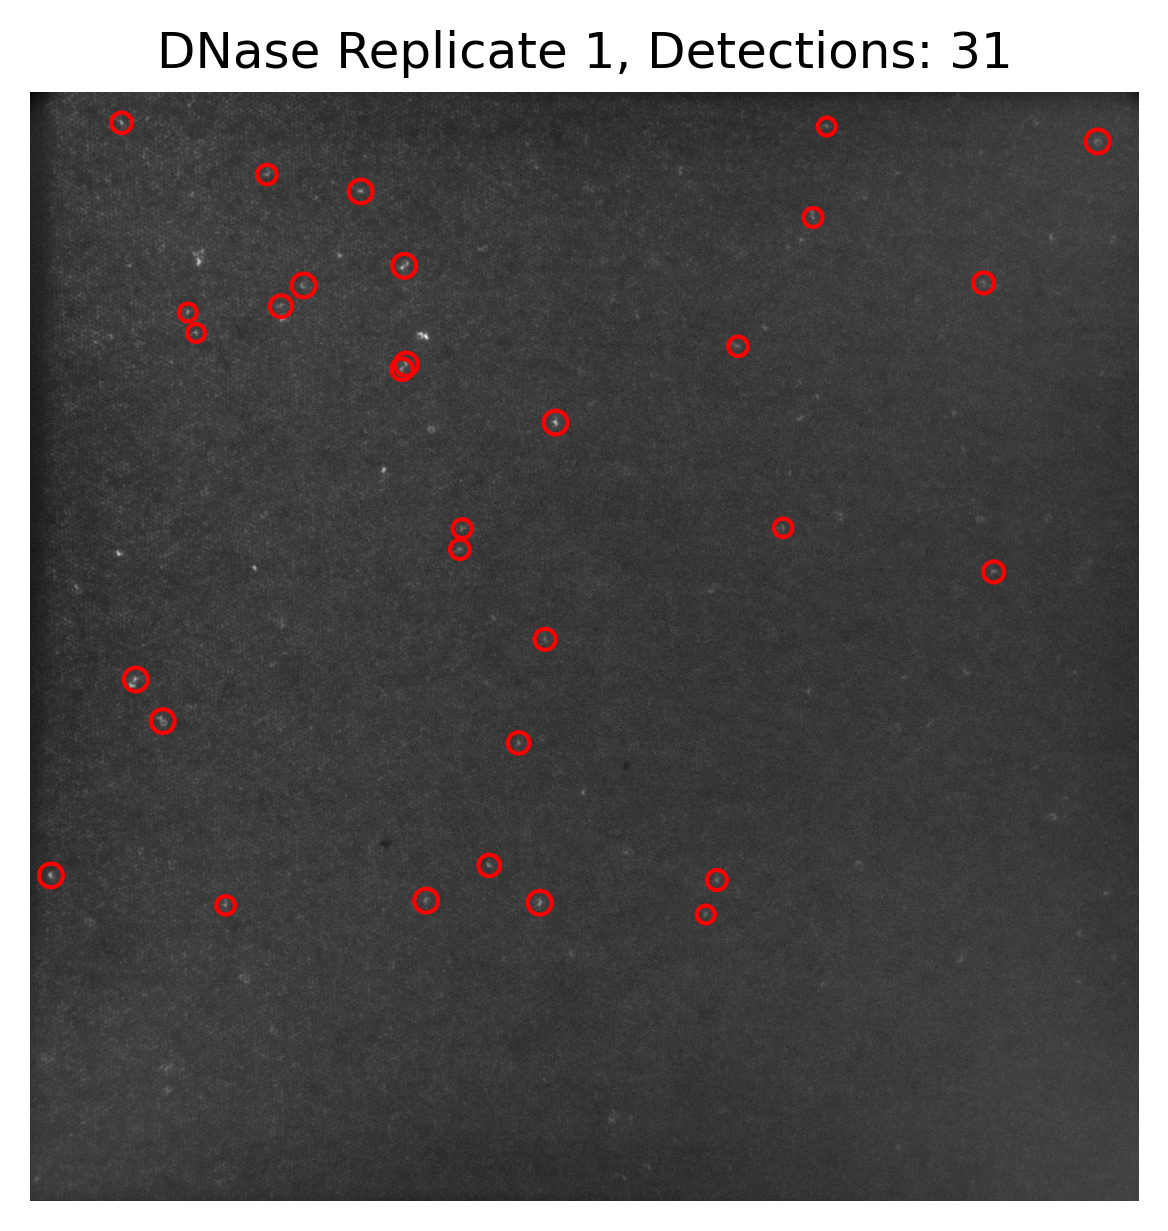

In [23]:
fig_alt, ax_alt = plt.subplots(dpi=300)
ax_alt.imshow(flattened_im_data[mem_layer-3], cmap='gray')
for region in region_im_filtered:
    y, x = region.centroid
    radius = np.sqrt(region.area / np.pi)

    circle = plt.Circle((x, y), np.where(radius*5 < 15, radius*5, 15), fill=False, edgecolor='red')
    ax_alt.add_patch(circle)
   
ax_alt.invert_yaxis()
plt.axis('off')
plt.title(os.path.basename(file_name).split('_')[0] + ' Replicate ' + os.path.basename(file_name).split('_')[1] + ', ' + 'Detections: ' + str(len(region_im_filtered)) )
plt.show()

In [24]:
voting_block = []
voting_block.append('STDEV')
voting_block.append('LAPLACE')
voting_block.append('TENENGRAD')
voting_block.append('SQUARED_GRAD')
voting_block.append('BRENNER')
vote_stats = []
for i in range(len(voting_power)):
    vote_stats.append([])

for i in range(len(vote_stats)):
    vote_stats[i] = (voting_block[i], voting_power[i])

In [25]:
for i in range(len(voting_power)):
    print(f'{voting_power[i][0]}, {voting_power[i][1]}')

30, 0.09073469718047247
31, 0.19001812125575054
29, 3.6530400407778307
29, 2.718326279286936
30, 0.23579941754396613


In [26]:
vote_stats

[('STDEV', (30, 0.09073469718047247)),
 ('LAPLACE', (31, 0.19001812125575054)),
 ('TENENGRAD', (29, 3.6530400407778307)),
 ('SQUARED_GRAD', (29, 2.718326279286936)),
 ('BRENNER', (30, 0.23579941754396613))]

In [27]:
dfCoords = pd.DataFrame(columns=['Centroid X', 'Centroid Y', 'Area', 'Eccentricity', 'Mean Intensity', 'Max Intensity'])
for part in region_im_filtered:
    dfCoords = dfCoords._append({'Centroid X': part.centroid[0], 
        'Centroid Y': part.centroid[1], 
        'Area': part.area, 
        'Eccentricity': part.eccentricity, 
        'Mean Intensity': part.mean_intensity, 
        'Max Intensity': part.intensity_max}, ignore_index=True)

/var/folders/p0/tb_jc0zs6z383snrfzw6d5_00000gn/T/ipykernel_56820/1837445146.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfCoords = dfCoords._append({'Centroid X': part.centroid[0],


In [28]:
dfCoords

,Centroid X,Centroid Y,Area,Eccentricity,Mean Intensity,Max Intensity
0,361.250000,852.750000,16.0,0.797246,214.062024,255.000000
1,372.764706,246.470588,17.0,0.412406,218.550701,255.000000
2,376.095238,642.976190,42.0,0.771574,228.421176,255.000000
3,378.733333,499.633333,30.0,0.793903,217.122933,255.000000
4,404.750000,866.650000,20.0,0.773636,210.656914,255.000000
5,410.571429,25.857143,35.0,0.614286,227.978517,255.000000
6,423.173913,579.260870,23.0,0.783491,228.397377,255.000000
7,577.913043,616.347826,23.0,0.825676,218.244332,255.000000
8,605.402778,167.055556,72.0,0.875265,218.816327,255.000000
9,657.888889,133.027778,36.0,0.486207,226.038772,255.000000


In [29]:
fft = np.fft.fft2(bud_matched)


In [30]:
masks = []
for prop in region_im_filtered:
    masks.append(prop.intensity_image)

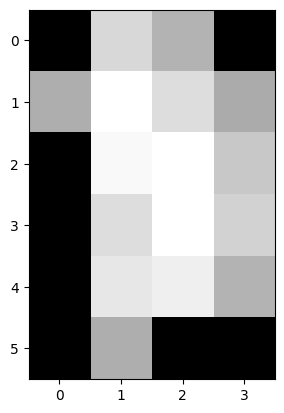

In [31]:
if len(masks) > 0:
    plt.imshow(masks[0], cmap='gray')

In [32]:
# # Need to use cv2.imwrite or else some small images will get corrupted! (Saved as 1-line RGB image? Weird)
# for i in range(len(masks)):
#     masks[i] = np.array(masks[i], dtype=np.uint8)
#     cv2.imwrite('/Users/moose/Desktop/trace_ca-local/LogRegImages/True/' + os.path.splitext(os.path.basename(file_name))[0] + '_mask_' + str(i) + '.tif', masks[i])

In [33]:
# import numpy as np
# from scipy.signal import convolve
# from scipy.ndimage import gaussian_filter

# def richardson_lucy(image, psf, iterations=30):
#     deconvolved = np.full(image.shape, 0.25)  # Initial guess
#     for _ in range(iterations):
#         convolved = convolve(deconvolved, psf, mode='same')
#         relative_blur = image / (convolved + 1e-10)
#         deconvolved *= convolve(relative_blur, psf[::-1, ::-1], mode='same')
#     return deconvolved

# # Create a synthetic PSF for this example
# psf = gaussian_filter(np.zeros((10, 10)), sigma=2)
# psf /= (psf.sum() + 1e-10)

# # Select a single plane from the z-stack for deconvolution
# image_to_deconvolve = image_data[28]  # Example: select the 11th plane

# # Apply deconvolution
# deconvolved_image = richardson_lucy(image_to_deconvolve, psf, iterations=30)

# # Display the result
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(image_to_deconvolve, cmap='gray')
# plt.title('Original Image')

# plt.subplot(1, 2, 2)
# plt.imshow(deconvolved_image, cmap='gray')
# plt.title('Deconvolved Image')

# plt.show()

In [34]:
# import numpy as np
# import scipy.fftpack as fft

# def wiener_deconvolution(image_data, psf, nsr=0.1):
#     padded_psf = np.zeros_like(image_data)
#     psf_shape = np.array(psf.shape)
#     start = (np.array(padded_psf.shape) - psf_shape) // 2
#     end = start + psf_shape
#     padded_psf[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = psf

#     # Fourier Transform of the image_data and padded_psf
#     image_data_ft = fft.fftn(image_data)
#     psf_ft = fft.fftn(padded_psf)
    
#     # Creating the Wiener filter
#     H = np.conj(psf_ft) / (np.abs(psf_ft)**2 + nsr)
    
#     # Applying the Wiener filter
#     deconvolved_ft = image_data_ft * H
    
#     # Inverse Fourier Transform to get the spatial domain result
#     deconvolved = np.abs(fft.ifftn(deconvolved_ft))
    
#     return deconvolved

In [35]:
# def generate_gaussian_psf(size, sigma_xy, sigma_z):
#     """
#     Generate a 3D Gaussian PSF.

#     Parameters:
#     - size: tuple of int, the size of the PSF in (z, y, x).
#     - sigma_xy: float, the standard deviation of the Gaussian in the XY plane.
#     - sigma_z: float, the standard deviation of the Gaussian along the Z axis.

#     Returns:
#     - psf: 3D numpy array, the generated PSF.
#     """
#     z, y, x = np.indices(size) - np.array(size)[:, None, None, None] / 2
#     psf = np.exp(-(x**2 + y**2) / (2 * sigma_xy**2) - z**2 / (2 * sigma_z**2))
#     return psf / psf.sum()

# # Example usage
# psf = generate_gaussian_psf(size=(len(image_data), image_data[0].shape[0], image_data[0].shape[1]), sigma_xy=1.5, sigma_z=5)

In [36]:
# norm_im = []
# ubyte_im = []

# for i in range(len(image_data)):
#     norm_im.append((image_data[i] - np.min(image_data[i])) / (np.max(image_data[i]) - np.min(image_data[i])))
#     ubyte_im.append(img_as_ubyte(norm_im[i]))

In [37]:
# deconv_im = wiener_deconvolution(ubyte_im, psf, nsr=0.2)

In [38]:
# from skimage import color, data, restoration
# import numpy as np
# import matplotlib.pyplot as plt

# # Perform blind deconvolution
# deconvolved_img, estimated_psf = restoration.unsupervised_wiener(bud_sub, np.ones((6, 6)))

In [39]:
# plt.figure(figsize=(15, 5), dpi=300)

# plt.subplot(1, 3, 1)
# plt.imshow(bud_sub, cmap='gray')
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(deconvolved_img, cmap='gray')
# plt.title('Deconvolved Image')
# plt.axis('off')

# plt.show()

In [40]:
# import numpy as np
# import matplotlib.pyplot as plt

# from scipy.signal import convolve2d as conv2

# from skimage import color, data, restoration

# from scipy.ndimage import gaussian_filter

# # Create a delta function image
# psf_size = 21  # Choose an odd number to have a central pixel
# delta = np.zeros((psf_size, psf_size))
# delta[psf_size // 2, psf_size // 2] = 1

# # Apply Gaussian filter to create a Gaussian PSF
# sigma = 1  # Adjust sigma to control the spread of the blur
# psf_gaussian = gaussian_filter(delta, sigma=sigma)
# psf_gaussian /= psf_gaussian.sum()  # Normalize the PSF

# rng = np.random.default_rng()

# psf = np.ones((5, 5)) / 25
# bsc = conv2(bud_sub, psf_gaussian, 'same')
# deconvolved_RL = restoration.richardson_lucy(bsc, psf, num_iter=30)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
# plt.gray()

# for a in (ax[0], ax[1]):
#     a.axis('off')

# ax[0].imshow(bsc)
# ax[0].set_title('Original Data')

# ax[1].imshow(deconvolved_RL)
# ax[1].set_title('Richardson-Lucy')

# fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
# plt.show()
